# CS145: Project 3 | Prediction on Getting a Desirable Answer on Stack Overflow

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Xiaokun Chen, xiaokunc*
* *Zherui Lin, zherui*


## Project Overview
---


Stack Overflow is a question-and-answer website for professional and enthusiast programmers. It features questions and answers on a wide range of topics in computer programming.

The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down. Users of Stack Overflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on a question or an answer to a question, and can receive badges for their valued contributions. Users unlock new privileges with an increase in reputation like the ability to vote, comment, and even edit other people's posts.

Each question posted has some tags assigned to it, indicating the content of the question, like JavaScript, Java, C#, PHP, and so forth. When replied by answers, the question owner can choose one answer as the accepted answer, which can be considered as the completion of the question post. But some lazy question owners are forgetting to confirm the accepted answer even if some answers are pretty good. Thus we can also define some answers as 'equally good answers even if there is not an existent accepted answer for the corresponding question.

The central problem we are curious about is that given a newly posted question, whether and how long it will be answered by either an accepted answer or an equally-good answer (i.e., a desirable answer) based on its information and its owner's information.



## Analysis of Dataset
---

We use the stackoverflow dataset in the BigQuery Public Dataset for our project.

The stackoverflow data set has 17 tables. However, we mainly use the following 5 tables: post_answers(26.75 GB, but we won’t use the body column, therefore the size reduces to around 2GB), post_questions(34.57 GB, but we also ignore the body column, so the size reduces to 3GB), users(2.53 GB), tags(2.4 MB), and badges(1.75 GB). In total, around 10 GB. 

The post_answers table contains the answer id, creation date, score (numbers of up-votes minus down-votes), question id, and the user id of the answer. The primary key is the answer id, and one foreign key is the user id, which can tell us who posted this answer.

The post_questions table contains the question id, question title, accepted answer id, answer count, comment count, creation date, favorite (bookmark) count, user id, score (numbers of up-votes minus down-votes), tags, and view count of the question.  The primary key is the question id, and two foreign keys are the accepted answer id and the user id, which connect with the post_answers table and the users table.

The users table contains user id, reputation value, up-votes, down-votes, and view count. The primary key is the user id.

The tags table contains the tag name and count for all questions with the tag. The primary key is the tag name.

The badges table contains the badge name, class, and user id of who owns it. All three columns are the primary keys in this table, and the user id is a foreign key.



## Data Exploration
---

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs-145-project-3-own"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Add imports for any visualization libraries you may need
import matplotlib.pyplot as plt

%matplotlib inline

### Step 1: Define an equally good answer for a question without an accepted answer

As mentioned above, a posted question may not have an accepted answer just because of the laziness of the question owner. Some answers for questions without an accepted answer may be also good. Thus we should define the criterion for an equally-good answer. One feature we can consider is the ratio of the answer score by the view count of the question (i.e., **effective ratio**), which reflects the probability of agreement from other users who viewed this question. If the effective ratio of an answer is greater than a fixed threshold, we can consider the answer to be an equally good answer.

**a) The distribution of the effective ratio of answers for questions that do not have an accepted answer**

Since we are only looking for good answers, answers with negative or zero scores (i.e., not much agreement on them) can be ignored. Focusing on answers for questions that do not have an accepted answer, we should try to find the distribution of the effective ratio. We can then find a suitable threshold based on that distribution.

In [ ]:
%%bigquery --project cs-145-project-3-own s1a

SELECT
  a.score / b.view_count AS effective_ratio
FROM
  `bigquery-public-data.stackoverflow.posts_answers` AS a
JOIN
  `bigquery-public-data.stackoverflow.posts_questions` AS b
ON
  a.parent_id = b.id
WHERE
  b.accepted_answer_id IS NULL
  AND a.score > 0 

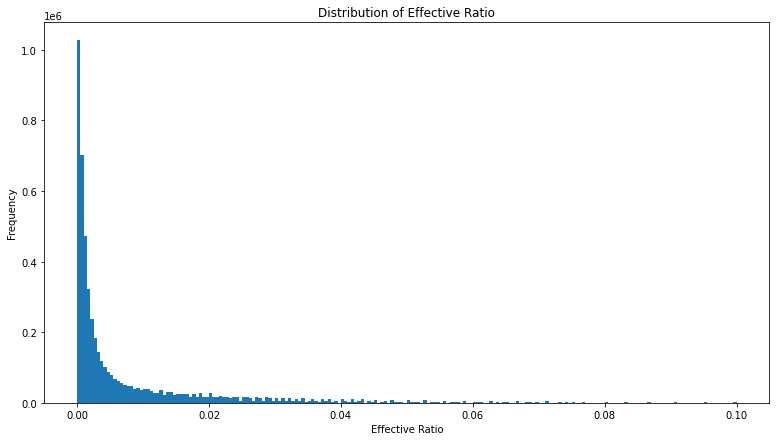

In [ ]:
plt.figure(figsize=(13, 7));
plt.hist(s1a["effective_ratio"],200,[0,0.1]);
plt.title("Distribution of Effective Ratio");
plt.xlabel("Effective Ratio");
plt.ylabel("Frequency");

**b) Decide the threshold on the effective ratio for equally good answers**

From the distribution histogram, we can find most answers have a really low effective ratio, which should not be considered as good answers. Good answers should be something precious with relatively low frequency, thus we can decide 0.01 as the threshold for the effective ratio, which means answers with an effective ratio greater than **0.01** can be considered as equally-good answers. This belongs to part of our feature engineering.


### Step 2: Analyze the distribution of time waiting for an desirable answer

The original dataset does not explicitly show whether a question was answered by either an accepted answer or an equally-good answer (i.e., a desirable answer) and how long a question was answered by that. Thus we should explore them first. 

**a) The percentage of questions that was answered by a desirable answer.**

Not every question will be finally answered by a desirable answer. We can first explore what percentage of questions were finally answered by a desirable answer.

In [ ]:
%%bigquery --project cs-145-project-3-own

SELECT
  ROUND(COUNTIF(id IN (
      SELECT
        DISTINCT b.id
      FROM
        `bigquery-public-data.stackoverflow.posts_answers` AS a
      JOIN
        `bigquery-public-data.stackoverflow.posts_questions` AS b
      ON
        a.parent_id = b.id
      WHERE
        b.accepted_answer_id IS NULL
        AND a.score / b.view_count > 0.01)
      OR accepted_answer_id IS NOT NULL) / COUNT(*) * 100, 2) AS percentage_of_questions_with_desirable_answer
FROM
  `bigquery-public-data.stackoverflow.posts_questions`

,percentage_of_questions_with_desirable_answer
0,55.95


We can find about 56% of the questions were finally answered by a desirable answer, which surprises us since near half of questions were never replied by a desirable answer. Thus it is quite meaningful to predict whether a question will receive a desirable answer or not.

**b) The distribution of time waiting for a desirable answer.**

Among questions with desirable answers, we can then analyze the distribution of time waiting for the desirable answer. For questions with an accepted answer, we can just calculate the duration from the creation date of the question to the creation date of the accepted answer. For questions without an accepted answer but with equally-good answers, we can only calculate the duration from the creation date of the question to the creation date of the **first** equally-good answer.

To simplify our problem and to make it more realistic, we round up the waiting time to the nearest hour. For example, if the waiting time is 10 minutes, we round it up to one hour; if the waiting time is 12 hours and 30 seconds, we round it up to 13 hours. Thus our prediction output will also be in the unit of the hour. 

In [ ]:
%%bigquery --project cs-145-project-3-own s2b

SELECT
  id,
  waiting_hour
FROM (
  SELECT
    b.id,
    EXTRACT(HOUR
    FROM
      MIN(a.creation_date - b.creation_date)) + 1 AS waiting_hour
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` AS a
  JOIN
    `bigquery-public-data.stackoverflow.posts_questions` AS b
  ON
    a.parent_id = b.id
  WHERE
    b.accepted_answer_id IS NULL
    AND a.score / b.view_count > 0.01
    AND a.creation_date > b.creation_date
  GROUP BY
    b.id)
UNION ALL (
  SELECT
    b.id,
    EXTRACT(HOUR
    FROM (a.creation_date - b.creation_date)) + 1 AS waiting_hour
  FROM
    `bigquery-public-data.stackoverflow.posts_answers` AS a
  JOIN
    `bigquery-public-data.stackoverflow.posts_questions` AS b
  ON
    a.ID = b.accepted_answer_id
  WHERE
    a.creation_date > b.creation_date)

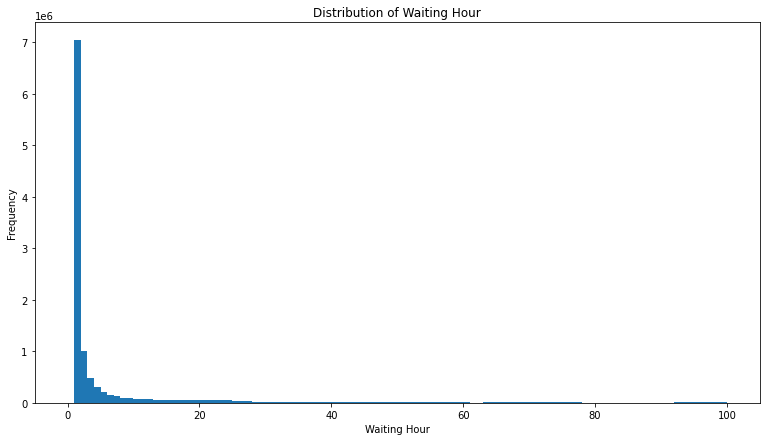

In [ ]:
plt.figure(figsize=(13, 7));
plt.hist(s2b["waiting_hour"],100,[0,100]);
plt.title("Distribution of Waiting Hour");
plt.xlabel("Waiting Hour");
plt.ylabel("Frequency");

The range of the x-axis above is from 0 to 100 hours. We can find nearly all questions were answered by desirable answers within one day, and most questions were answered within one hour, which means Stack Overflow is quite an active platform.

The uneven distribution result is not good news for our prediction objective. What we expected to predict is the waiting hour, and it was supposed to be continuously distributed over a wide range. But the result indicates the waiting hour concentrates at some special values, thus it is not an ideal output for a prediction regression.

**Finally we decided to focus on the problem that whether a newly posted question will be ever replied to by a desirable answer.**

### Step 3: Discuss suitable features for prediction

As mentioned above, our prediction is based on the question information and the question owner's behaviors. 

The length of the body of the question might have a great effect on the prediction result. Usually, questions with long descriptions cannot be answered in time, thus it might be an important feature for us.

Tags are the related topics to a specific question. Questions with popular tags will receive desirable answers more easily. Each question has several tags, and we can split the tags string into every single tag string and simply put them as one feature.

Some other features may come from the behavior or information of the question owner, like the reputation value, net votes received (i.e., up-votes minus down-votes), view count, and badge numbers. These features reflect the activity level, prestige, and contributions of the question owner. A question from a user with those high features might tend to be viewed more frequently by other users, resulting in a high probability of receiving desirable answers.

### Step 4: Extract training data

To predict whether a newly posted question will receive a desirable answer, we should extract the result label and input features we need from the original dataset. The result below displays the first 10 rows of the table returned by our extraction.

In [ ]:
%%bigquery --project cs-145-project-3-own

SELECT
IF
  (a.id IN (
    SELECT
      DISTINCT b.id
    FROM
      `bigquery-public-data.stackoverflow.posts_answers` AS a
    JOIN
      `bigquery-public-data.stackoverflow.posts_questions` AS b
    ON
      a.parent_id = b.id
    WHERE
      b.accepted_answer_id IS NULL
      AND a.score / b.view_count > 0.01)
    OR accepted_answer_id IS NOT NULL,
    1,
    0) AS label,
  LENGTH(a.body) AS body_length,
  SPLIT(a.tags, '|') AS tags_array,
  b.reputation,
  b.up_votes-b.down_votes AS net_votes,
  b.views,
  e.badge_number
FROM
  `bigquery-public-data.stackoverflow.posts_questions` AS a,
  `bigquery-public-data.stackoverflow.users` AS b,
  (
  SELECT
    c.id,
    COUNT(DISTINCT d.id) AS badge_number
  FROM
    `bigquery-public-data.stackoverflow.users` AS c
  JOIN
    `bigquery-public-data.stackoverflow.badges` AS d
  ON
    c.id = d.user_id
  GROUP BY
    c.id) AS e
WHERE
  a.owner_user_id = b.id
  AND b.id = e.id
LIMIT
  10

,label,body_length,tags_array,reputation,net_votes,views,badge_number
0,1,746,"[oracle, oracle11g, tns]",3640,200,253,71
1,1,527,"[java, android, user-interface, fragment]",536,37,240,36
2,0,3363,"[vba, ms-access]",15,0,12,3
3,1,1154,"[excel, vba]",2348,99,362,115
4,1,809,[r],143,0,28,6
5,1,756,"[asp.net, aspnetboilerplate]",3,0,9,7
6,0,1986,"[android, http-post, android-webview]",31,0,5,2
7,0,352,"[python, fonts, truetype]",21,0,5,3
8,0,1511,"[java, html, url]",625,233,71,26
9,1,411,"[linux, bash, command-line]",11100,88,616,269


## Data Prediction
---

### Step 1: Create a dataset to store the model

In [ ]:
model_dataset_name = 'bqml_stackoverflow'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

### Step 2: Separate training, validation, and test sets

**a) Some unusual spliting pitfalls.**

At first, we intended to split the train, validation, and test set by creation time of the question might be a good option. However, after training the first batch of models, we reflected and discovered that this way of splitting data deviates from the principle of using repeated data in training and testing. The hidden secret is that our feature selection mainly relies on the behavior of the question owner and the tags of the question. Therefore, if the same user raises one question in our “training set” and also raises a new question in our validation or test sets, the information of the same user would be reused. 

**b) Final split decisions.**

Thus, in the end, we adopted a new way of splitting, which splits the user as 8:1:1 for training, validation, and testing set. We know that each user(i.e., unique user ID) could raise several questions. However, since we choose uses randomly, after mapping users to their questions, the ratio of training, validation, and testing set for questions is still 8:1:1. In this case, when we receive a new question, we could use the features of the question itself, such as the tags and the features of the question owner, to interpolate whether it would be qualitatively answered or not.

We will train on questions with owner ID less than 13500000, and evaluate on owner ID between 13500000 and 15000000, and finally test on owner ID greater than 135000000. In this case, the ratio of the three datasets will be near 8:1:1.

### Step 3: Train the model

For prediction on whether a newly posted question will be replied to by a desirable answer, the dataset should be the whole original dataset, and the output (label) type should be a boolean value (answered or not answered).

In [ ]:
%%bigquery --project cs-145-project-3-own

CREATE OR REPLACE MODEL
  `bqml_stackoverflow.stackoverflow_model` OPTIONS(model_type = 'logistic_reg') AS
SELECT
IF
  (a.id IN (
    SELECT
      DISTINCT b.id
    FROM
      `bigquery-public-data.stackoverflow.posts_answers` AS a
    JOIN
      `bigquery-public-data.stackoverflow.posts_questions` AS b
    ON
      a.parent_id = b.id
    WHERE
      b.accepted_answer_id IS NULL
      AND a.score / b.view_count > 0.01)
    OR accepted_answer_id IS NOT NULL,
    1,
    0) AS label,
  LENGTH(a.body) AS body_length,
  SPLIT(a.tags, '|') AS tags_array,
  b.reputation,
  b.up_votes-b.down_votes AS net_votes,
  b.views,
  e.badge_number
FROM
  `bigquery-public-data.stackoverflow.posts_questions` AS a,
  `bigquery-public-data.stackoverflow.users` AS b,
  (
  SELECT
    c.id,
    COUNT(DISTINCT d.id) AS badge_number
  FROM
    `bigquery-public-data.stackoverflow.users` AS c
  JOIN
    `bigquery-public-data.stackoverflow.badges` AS d
  ON
    c.id = d.user_id
  GROUP BY
    c.id) AS e
WHERE
  a.owner_user_id = b.id
  AND b.id = e.id
  AND b.id < 13500000

""


Below are the training statistics on our model.

In [ ]:
%%bigquery --project cs-145-project-3-own

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_stackoverflow.stackoverflow_model`)

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,4,0.644785,0.648873,3.2,36937
1,0,3,0.648450,0.651161,1.6,40359
2,0,2,0.657139,0.658506,0.8,41717
3,0,1,0.670272,0.670843,0.4,40371
4,0,0,0.683494,0.683674,0.2,29318


### Step 4: Evaluate the model on the validation dataset



After creating the model, we can use the models and the validation dataset to evaluate the models.

In [ ]:
%%bigquery --project cs-145-project-3-own

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.stackoverflow_model`, (
SELECT
IF
  (a.id IN (
    SELECT
      DISTINCT b.id
    FROM
      `bigquery-public-data.stackoverflow.posts_answers` AS a
    JOIN
      `bigquery-public-data.stackoverflow.posts_questions` AS b
    ON
      a.parent_id = b.id
    WHERE
      b.accepted_answer_id IS NULL
      AND a.score / b.view_count > 0.01) OR accepted_answer_id IS NOT NULL,
    1,
    0) AS label,
  LENGTH(a.body) AS body_length,
  SPLIT(a.tags, '|') AS tags_array,
  b.reputation,
  b.up_votes-b.down_votes AS net_votes,
  b.views,
  e.badge_number
FROM
  `bigquery-public-data.stackoverflow.posts_questions` AS a,
  `bigquery-public-data.stackoverflow.users` AS b,
  (
  SELECT
    c.id,
    COUNT(DISTINCT d.id) AS badge_number
  FROM
    `bigquery-public-data.stackoverflow.users` AS c
  JOIN
    `bigquery-public-data.stackoverflow.badges` AS d
  ON
    c.id = d.user_id
  GROUP BY
    c.id) AS e
WHERE
  a.owner_user_id = b.id
  AND b.id = e.id
  AND b.id BETWEEN 13500000 AND 15000000))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.580932,0.723871,0.612859,0.644572,0.658853,0.659544


After evaluation, we can find the accuracy is greater than 61%, which is somehow acceptable for our prediction. And the precision also reaches 58%, which can provide relatively stable results.

It is not the first time we evaluate the model on the validation set. We have adjusted our input features several times based on the evaluation results. For example, in the end, when trying different feature selections, we add the length of the question body as one feature. The intuitive thought is as the body length grows, the question owner would have deep or sophisticated thoughts about the question. The probability of getting qualitatively answered could decrease. But this idea is not supported by increasing the accuracy of the model.    

### Step 5: Evaluate the final model on the test dataset

Finally, we should use the model and the test dataset to evaluate the final models.

In [ ]:
%%bigquery --project cs-145-project-3-own

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_stackoverflow.stackoverflow_model`, (
SELECT
IF
  (a.id IN (
    SELECT
      DISTINCT b.id
    FROM
      `bigquery-public-data.stackoverflow.posts_answers` AS a
    JOIN
      `bigquery-public-data.stackoverflow.posts_questions` AS b
    ON
      a.parent_id = b.id
    WHERE
      b.accepted_answer_id IS NULL
      AND a.score / b.view_count > 0.01) OR accepted_answer_id IS NOT NULL,
    1,
    0) AS label,
  LENGTH(a.body) AS body_length,
  SPLIT(a.tags, '|') AS tags_array,
  b.reputation,
  b.up_votes-b.down_votes AS net_votes,
  b.views,
  e.badge_number
FROM
  `bigquery-public-data.stackoverflow.posts_questions` AS a,
  `bigquery-public-data.stackoverflow.users` AS b,
  (
  SELECT
    c.id,
    COUNT(DISTINCT d.id) AS badge_number
  FROM
    `bigquery-public-data.stackoverflow.users` AS c
  JOIN
    `bigquery-public-data.stackoverflow.badges` AS d
  ON
    c.id = d.user_id
  GROUP BY
    c.id) AS e
WHERE
  a.owner_user_id = b.id
  AND b.id = e.id
  AND b.id > 15000000))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.556524,0.722495,0.606189,0.628741,0.662074,0.656955


## Conclusion, and future improvements
---

The conclusion of our journey of exploring and predicting the Stack Overflow question data is that the seemingly related data could have a little relationship. For instance, we conceive that the length of the body has high relevance to the fast response of the answer. Unfortunately, it does not. After adding the feature, the accuracy increases by less than 0.5%. However, the tags do have a strong relationship with it. We get an increase of 10 % after adding the processed tag data. Furthermore, we also learn a lesson about how to engineer different features, for example, the effective ratio, the tags_array, net_votes, and the length of the question body. Those additional inferred and processed features could contribute to a more accurate model.

There is also another amazing thing we found. At first, we expected to predict one problem (how long a question will be answered). But after exploring the raw dataset, we finally found another problem (whether a question will be qualitatively answered) that is more meaningful. That is a good lesson we learned.

For future work, we could add more sophisticated engineered features such as the history of the qualitatively answered ratio of the questioner. Also, we could further observe the recommendation algorithm of the stackoverflow system to interpolate other useful engineered features, optimizing the potential algorithm that pushes more questions to the potential respondent according to the user portrait.
